# Setting the Seed for Reproducibility

In [1]:
import warnings
warnings.filterwarnings("ignore")

def set_seed(seed=123):
    import random
    import numpy as np
    import tensorflow as tf
    import warnings
    warnings.filterwarnings("ignore")
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

SEED = 123
set_seed(SEED)


# Loading and Splitting the Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset and handle negative values
def load_data(file_path):
    data = pd.read_csv(file_path)
    
    # Handle negative and zero values before log transformation
    data['Current Assets'] = data['Current Assets'].apply(lambda x: x if x > 0 else np.nan)
    data['Total Liabilities'] = data['Total Liabilities'].apply(lambda x: x if x > 0 else np.nan)
    
    # Apply modified log transformation to highly skewed features
    def modified_log_transform(x):
        return np.sign(x) * np.log1p(np.abs(x))
    
    data['Current Assets'] = modified_log_transform(data['Current Assets'])
    data['Net Income'] = modified_log_transform(data['Net Income'])
    data['EBIT'] = modified_log_transform(data['EBIT'])
    data['Retained Earnings'] = modified_log_transform(data['Retained Earnings'])
    data['Total Liabilities'] = modified_log_transform(data['Total Liabilities'])
    
    # Drop rows with NaN values resulting from the log transformation
    data = data.dropna(subset=['Current Assets', 'Total Liabilities'])
    
    # Define features and target
    X = data.drop('Target', axis=1)
    y = data['Target']
    
    return X, y

# Split the data into training and test sets
def split_data(X, y, test_size=0.3, seed=123):
    return train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

# Define file path and load data
file_path = 'merged_bankruptcy_data.csv'
X, y = load_data(file_path)

# Split the data
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.3, seed=123)

# Check the shapes of the datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())


Training set shape: (57476, 5)
Test set shape: (24633, 5)
Training set class distribution:
 Target
0    55069
1     2407
Name: count, dtype: int64
Test set class distribution:
 Target
0    23602
1     1031
Name: count, dtype: int64


# Evaluating the Model

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def evaluate_model(model, X_test, y_test, y_pred, y_pred_prob):
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Precision
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)

    # Recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("ROC-AUC:", roc_auc)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Classification Report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    # Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_scores = cross_val_score(model, X_test, y_test, cv=cv, scoring='accuracy')
    print("Cross-Validation Scores:", cv_scores)
    print("Mean Cross-Validation Score:", cv_scores.mean())

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label='Model (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    #plot the confusion matrix
    import seaborn as sns
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


# Training and Evaluating Function

In [4]:
def train_and_evaluate_model(model, param_grid, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('classifier', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)
    
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    evaluate_model(best_model, X_test, y_test, y_pred, y_pred_prob)
    return best_model


# Training and Evaluating a Random Forest Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Accuracy: 0.9997970202573783
Precision: 0.9980582524271845
Recall: 0.997090203685742
F1 Score: 0.997573993207181
ROC-AUC: 0.9999956438944537
Confusion Matrix:
 [[23600     2]
 [    3  1028]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99979704 0.99878222 0.99979704 0.999797   0.999797  ]
Mean Cross-Validation Score: 0.9995940569917219


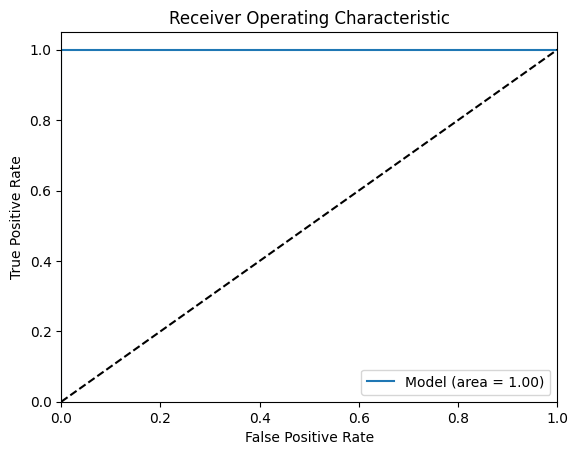

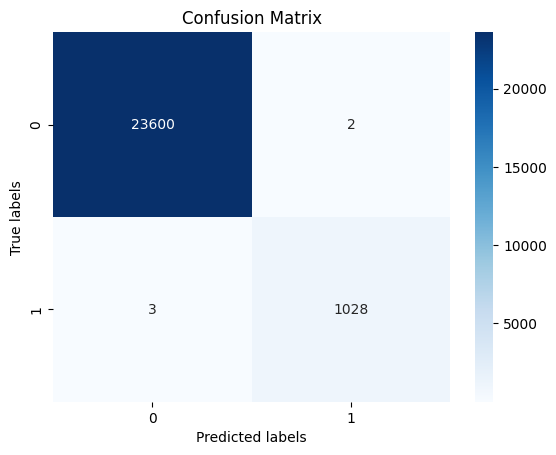

In [5]:
from sklearn.ensemble import RandomForestClassifier

set_seed(SEED)
rf_model = RandomForestClassifier(random_state=SEED)
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}
rf_model = train_and_evaluate_model(rf_model, rf_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a Support Vector Machine (SVM) Classifier

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Accuracy: 0.999756424308854
Precision: 0.9951690821256038
Recall: 0.9990300678952473
F1 Score: 0.9970958373668926
ROC-AUC: 0.9999578361859387
Confusion Matrix:
 [[23597     5]
 [    1  1030]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99979704 0.99918815 0.99979704 0.99959399 0.999797  ]
Mean Cross-Validation Score: 0.999634641403962


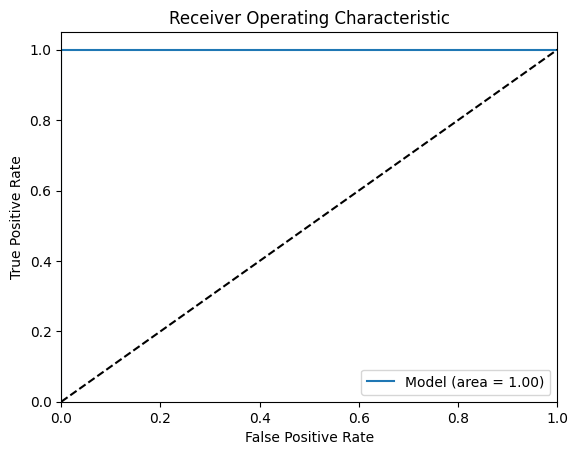

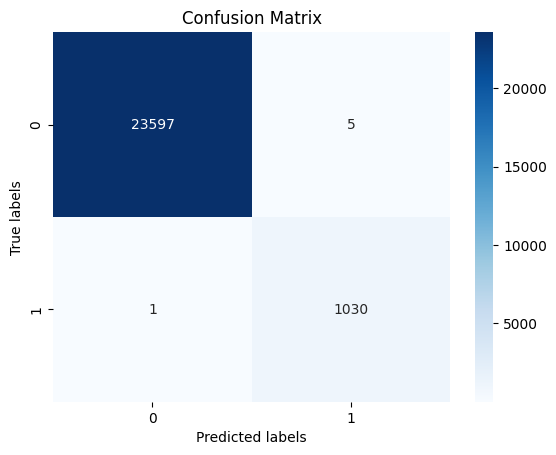

In [6]:
from sklearn.svm import SVC

set_seed(SEED)
svm_model = SVC(probability=True, random_state=SEED)
svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto']
}
svm_model = train_and_evaluate_model(svm_model, svm_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a Gradient Boosting Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Accuracy: 0.999756424308854
Precision: 0.997090203685742
Recall: 0.997090203685742
F1 Score: 0.997090203685742
ROC-AUC: 0.9999936302230219
Confusion Matrix:
 [[23599     3]
 [    3  1028]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99898518 1.         0.99959399 0.999797  ]
Mean Cross-Validation Score: 0.9995940487512319


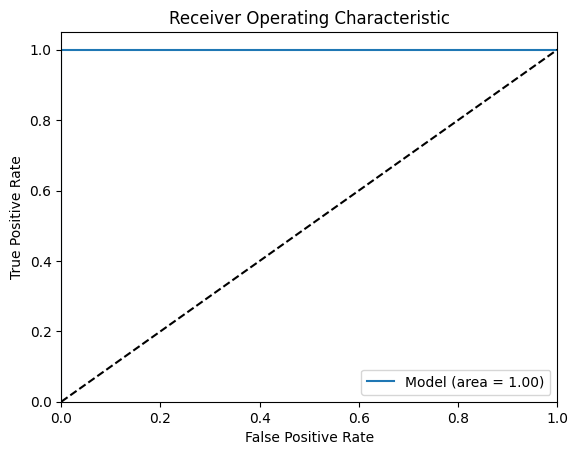

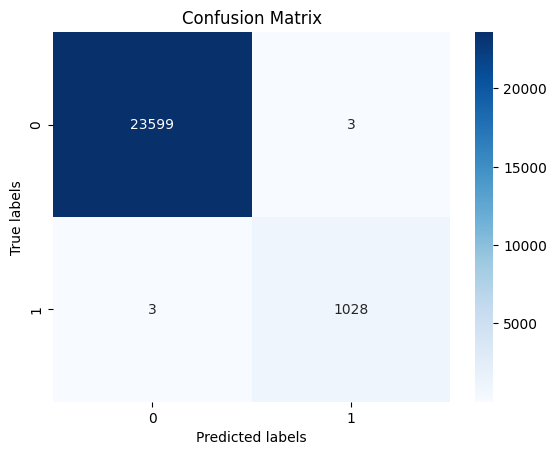

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

set_seed(SEED)
gb_model = GradientBoostingClassifier(random_state=SEED)
gb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}
gb_model = train_and_evaluate_model(gb_model, gb_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating an XGBoost Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Accuracy: 0.9998376162059026
Precision: 0.9970958373668926
Recall: 0.9990300678952473
F1 Score: 0.998062015503876
ROC-AUC: 0.9999960959431424
Confusion Matrix:
 [[23599     3]
 [    1  1030]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99898518 1.         0.99959399 0.99959399]
Mean Cross-Validation Score: 0.9995534478580124


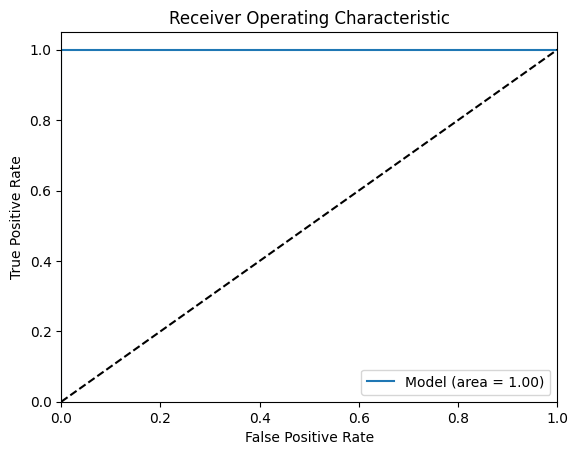

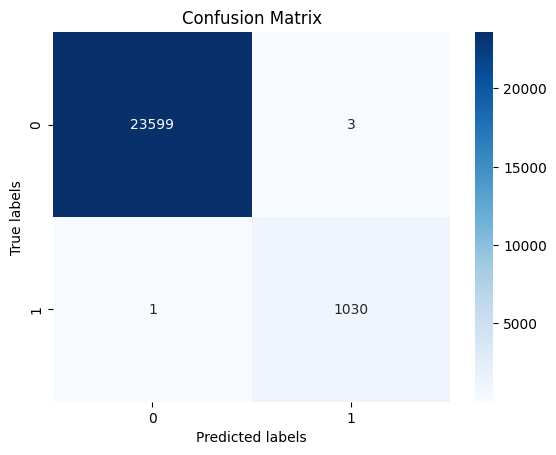

In [8]:
from xgboost import XGBClassifier

set_seed(SEED)
xgb_model = XGBClassifier(random_state=SEED)
xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}
xgb_model = train_and_evaluate_model(xgb_model, xgb_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a CatBoost Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'classifier__depth': 5, 'classifier__iterations': 200, 'classifier__learning_rate': 0.2}
Accuracy: 0.9998376162059026
Precision: 0.9970958373668926
Recall: 0.9990300678952473
F1 Score: 0.998062015503876
ROC-AUC: 0.9999992191886284
Confusion Matrix:
 [[23599     3]
 [    1  1030]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99939111 0.99898518 1.         0.99959399 0.999797  ]
Mean Cross-Validation Score: 0.9995534560985021


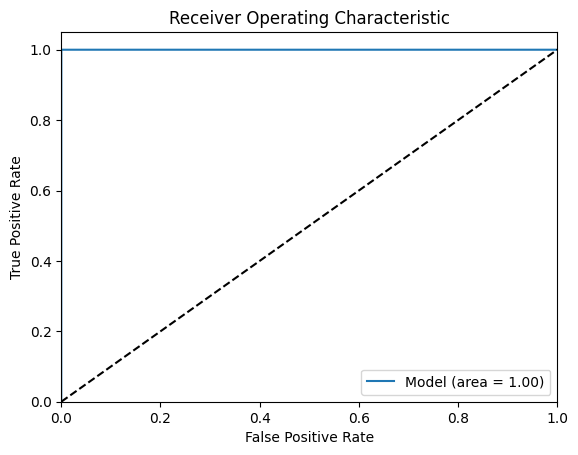

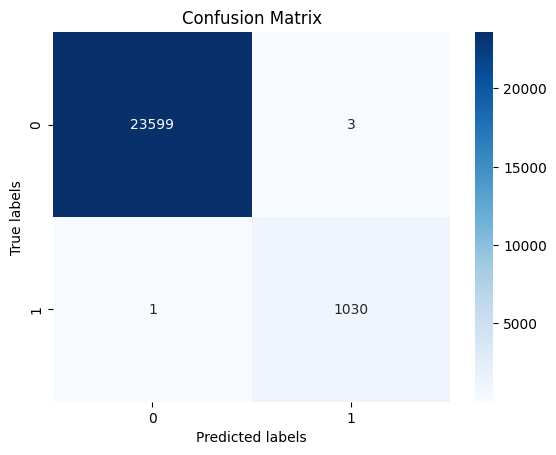

In [9]:
from catboost import CatBoostClassifier

set_seed(SEED)
catboost_model = CatBoostClassifier(random_state=SEED, verbose=0)
catboost_param_grid = {
    'classifier__iterations': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__depth': [3, 5, 7]
}
catboost_model = train_and_evaluate_model(catboost_model, catboost_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a K-Nearest Neighbors (KNN) Classifier

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Accuracy: 0.9997158283603297
Precision: 0.9932562620423893
Recall: 1.0
F1 Score: 0.9966167230546158
ROC-AUC: 0.9999575485185912
Confusion Matrix:
 [[23595     7]
 [    0  1031]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       0.99      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99878222 0.99979704 0.99918798 0.999797  ]
Mean Cross-Validation Score: 0.9994316616593331


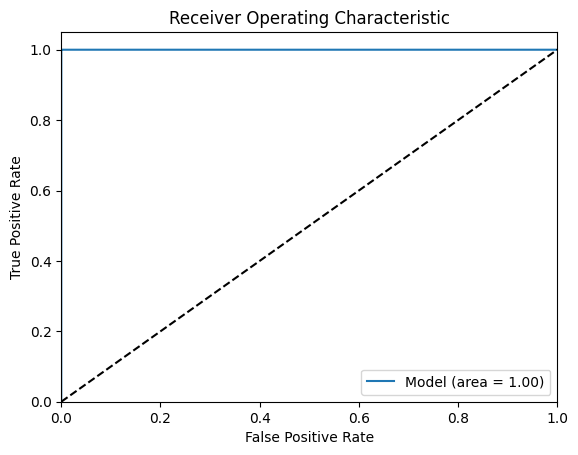

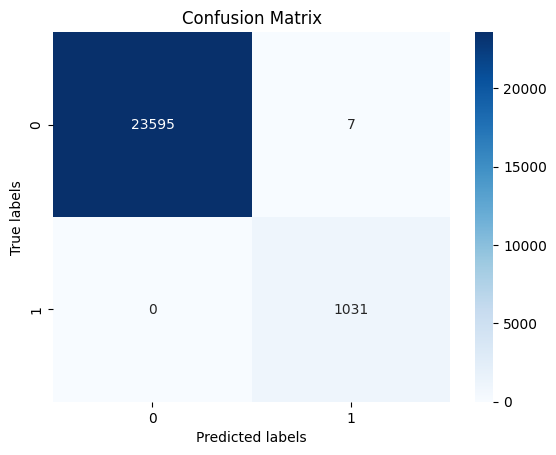

In [10]:
from sklearn.neighbors import KNeighborsClassifier

set_seed(SEED)
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}
knn_model = train_and_evaluate_model(knn_model, knn_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a Naive Bayes Classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'classifier__var_smoothing': 1e-09}
Accuracy: 0.9980513944708318
Precision: 0.9748792270531401
Recall: 0.9786614936954413
F1 Score: 0.9767666989351403
ROC-AUC: 0.9998933165094509
Confusion Matrix:
 [[23576    26]
 [   22  1009]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       0.97      0.98      0.98      1031

    accuracy                           1.00     24633
   macro avg       0.99      0.99      0.99     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99715851 0.99918815 0.99776695 0.99756395]
Mean Cross-Validation Score: 0.9982543264013509


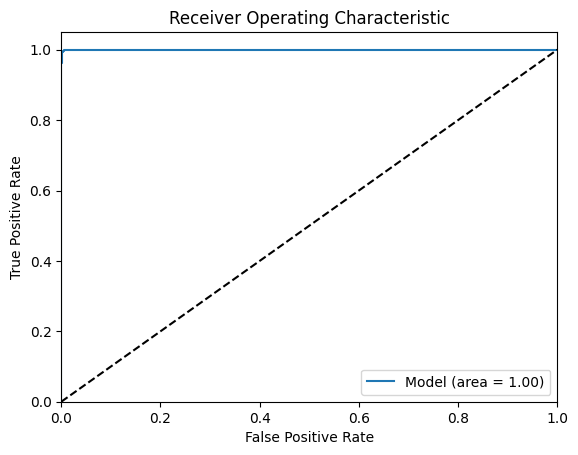

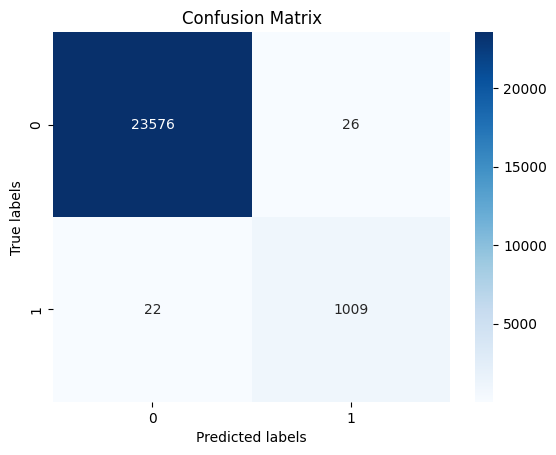

In [11]:
from sklearn.naive_bayes import GaussianNB

set_seed(SEED)
nb_model = GaussianNB()
nb_param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
}
nb_model = train_and_evaluate_model(nb_model, nb_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a Logistic Regression Classifier

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'classifier__C': 10, 'classifier__solver': 'saga'}
Accuracy: 0.9976860309341128
Precision: 0.9551401869158879
Recall: 0.991270611057226
F1 Score: 0.9728700618752975
ROC-AUC: 0.9994695003160642
Confusion Matrix:
 [[23554    48]
 [    9  1022]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       0.96      0.99      0.97      1031

    accuracy                           1.00     24633
   macro avg       0.98      0.99      0.99     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99817333 0.99594073 0.99857926 0.99796996 0.99736094]
Mean Cross-Validation Score: 0.9976048439576732


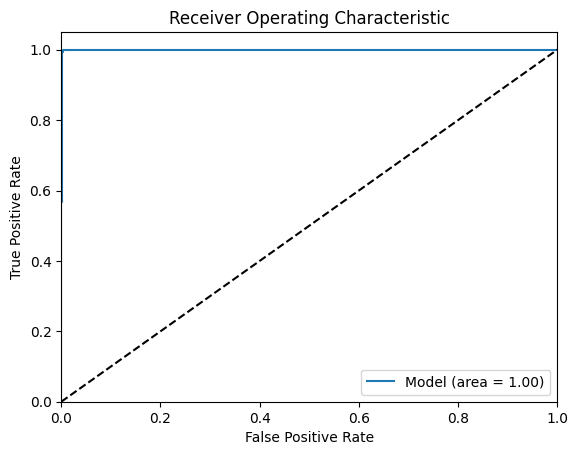

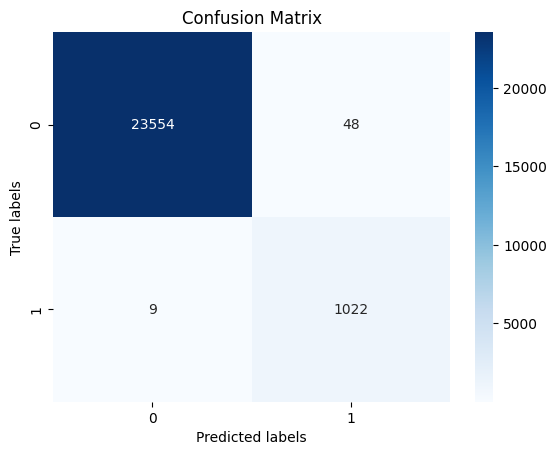

In [12]:
from sklearn.linear_model import LogisticRegression

set_seed(SEED)
lr_model = LogisticRegression(random_state=SEED, max_iter=10000)
lr_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga']
}
lr_model = train_and_evaluate_model(lr_model, lr_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a Decision Tree Classifier

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 10}
Accuracy: 0.9996752324118053
Precision: 0.9970845481049563
Recall: 0.9951503394762367
F1 Score: 0.996116504854369
ROC-AUC: 0.9979965202113845
Confusion Matrix:
 [[23599     3]
 [    5  1026]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99898518 0.99878222 0.99939111 0.99939099 0.99898498]
Mean Cross-Validation Score: 0.9991068957160248


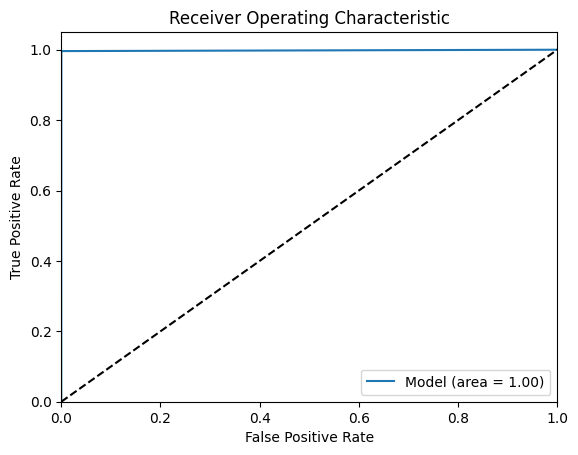

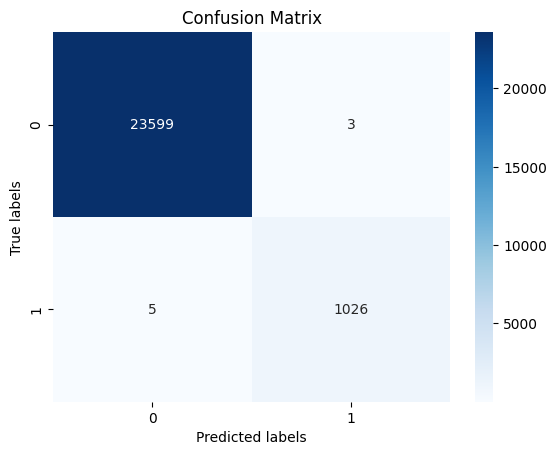

In [13]:
from sklearn.tree import DecisionTreeClassifier

set_seed(SEED)
dt_model = DecisionTreeClassifier(random_state=SEED)
dt_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}
dt_model = train_and_evaluate_model(dt_model, dt_param_grid, X_train, X_test, y_train, y_test)

# Training and Evaluating a AdaBoost Classifier

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}
Accuracy: 0.9996752324118053
Precision: 0.9942028985507246
Recall: 0.9980601357904947
F1 Score: 0.9961277831558567
ROC-AUC: 0.999978938640637
Confusion Matrix:
 [[23596     6]
 [    2  1029]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       0.99      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99939111 1.         0.99939099 0.99959399]
Mean Cross-Validation Score: 0.9995940322702526


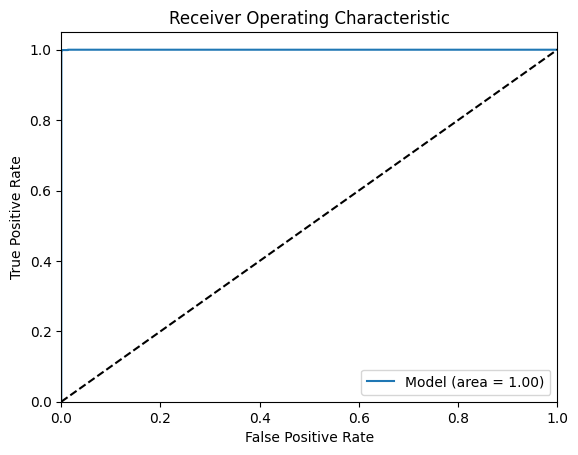

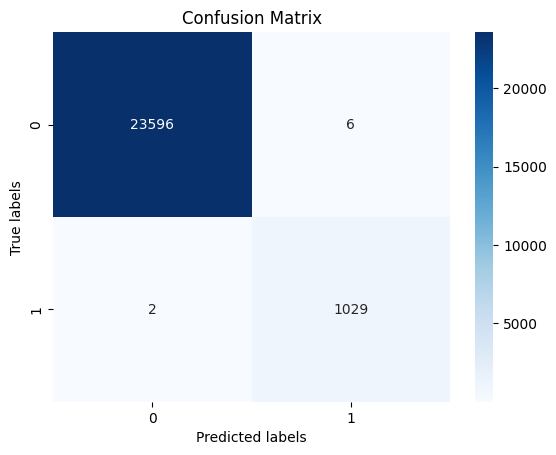

In [14]:
from sklearn.ensemble import AdaBoostClassifier

set_seed(SEED)
ada_model = AdaBoostClassifier(random_state=SEED)
ada_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}
ada_model = train_and_evaluate_model(ada_model, ada_param_grid, X_train, X_test, y_train, y_test)

# Training and Evaluating a Lightgbm Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy: 0.9996752324118053
Precision: 0.995159728944821
Recall: 0.997090203685742
F1 Score: 0.9961240310077519
ROC-AUC: 0.9999978219472268
Confusion Matrix:
 [[23597     5]
 [    3  1028]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99939111 0.99918815 1.         0.99959399 0.999797  ]
Mean Cross-Validation Score: 0.9995940487512319


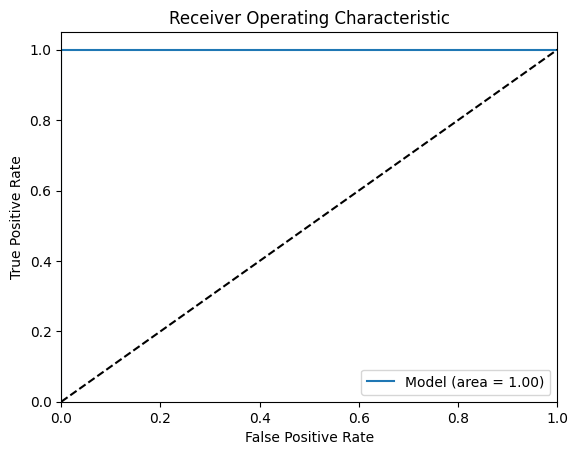

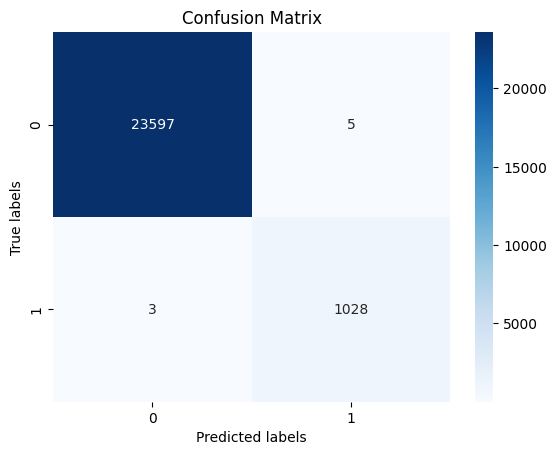

In [15]:
from lightgbm import LGBMClassifier

set_seed(SEED)
lgbm_model = LGBMClassifier(random_state=SEED, verbose=-1)
lgbm_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}
lgbm_model = train_and_evaluate_model(lgbm_model, lgbm_param_grid, X_train, X_test, y_train, y_test)

# Making Predictions on New Data

In [16]:
def predict_new_data(model, new_data):
    new_predictions = model.predict(new_data)
    print("Predictions for new data using", model.__class__.__name__, ":", new_predictions)

new_data = pd.DataFrame({
    'Current Assets': [233.211, 105.559, 63.971, 135.207, 82.589, 1.2164, 1.0049, 0.72926, 0.80974, 0.83593, 0.68673],
    'Net Income': [25.261, 129.688, -1.442, -20.401, -50.946, 1.281, 1.27, 1.0529, 1.1131, 1.0623, 1.0558],
    'EBIT': [31.521, 159.541, 13.994, 3.841, 2.061, 0.5251, 0.62288, 0.43292, 0.67546, 0.742, 0.77198],
    'Retained Earnings': [28.095, 157.783, 156.341, 135.941, 84.995, 0.18827, 0.18104, 0.044865, 0.091033, 0.0478, 0.043102],
    'Total Liabilities': [225.887, 880.327, 770.233, 776.697, 712.687, 0.022934, 0.0064542, -0.059379, -0.015229, 0.10702, 0.081916]
})


predict_new_data(rf_model, new_data)
predict_new_data(svm_model, new_data)
predict_new_data(gb_model, new_data)
predict_new_data(xgb_model, new_data)
predict_new_data(catboost_model, new_data)
predict_new_data(knn_model, new_data)
predict_new_data(nb_model, new_data)
predict_new_data(lr_model, new_data)
predict_new_data(dt_model, new_data)
predict_new_data(ada_model, new_data)
predict_new_data(lgbm_model, new_data)

Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using Pipeline : [0 0 0 0 0 1 1 1 1 1 1]


# Saving the Models

In [17]:
import joblib

joblib.dump(rf_model, 'imb_models/rf_model.pkl')
joblib.dump(svm_model, 'imb_models/svm_model.pkl')
joblib.dump(gb_model, 'imb_models/gb_model.pkl')
joblib.dump(xgb_model, 'imb_models/xgb_model.pkl')
joblib.dump(catboost_model, 'imb_models/catboost_model.pkl')
joblib.dump(knn_model, 'imb_models/knn_model.pkl')
joblib.dump(nb_model, 'imb_models/nb_model.pkl')
joblib.dump(lr_model, 'imb_models/lr_model.pkl')
joblib.dump(dt_model, 'imb_models/dt_model.pkl')
joblib.dump(ada_model, 'imb_models/ada_model.pkl')
joblib.dump(lgbm_model, 'imb_models/lgbm_model.pkl')



['imb_models/lgbm_model.pkl']

In [18]:
# Load the saved models
model_paths = [
    'imb_models/rf_model.pkl',
    'imb_models/svm_model.pkl',
    'imb_models/gb_model.pkl',
    'imb_models/xgb_model.pkl',
    'imb_models/catboost_model.pkl',
    'imb_models/knn_model.pkl',
    'imb_models/nb_model.pkl',
    'imb_models/lr_model.pkl',
    'imb_models/dt_model.pkl',
    'imb_models/ada_model.pkl',
    'imb_models/lgbm_model.pkl'
]

models = []
for path in model_paths:
    model = joblib.load(path)
    if hasattr(model, 'fit'):
        models.append(model)
    else:
        print(f"Error: Loaded object from {path} is not a valid model.")